# <center>Apple Inc. Stock Price Analysis and Forecasting</center>

# Importing Essential Libraries and Tools

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Loading the Data

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/Bhavanish19/Stocks_Analysis-/main/Apple.csv")

# Exploratory Data Analysis

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [7]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10444,2022-05-16,145.550003,147.520004,144.179993,145.539993,145.539993,86643800
10445,2022-05-17,148.860001,149.770004,146.679993,149.240005,149.240005,78336300
10446,2022-05-18,146.850006,147.360001,139.899994,140.820007,140.820007,109742900
10447,2022-05-19,139.880005,141.660004,136.600006,137.350006,137.350006,136095600
10448,2022-05-20,139.089996,140.699997,132.610001,137.589996,137.589996,137194600


As we can see, there are 1918 trading days even though the number of days in this period of time is much larger than 1918. This is because the stock market is not open on weekend and some USA's speacial days such as Independence day, Christmas Day, New Year's Eve and so forth.

In [8]:
df.shape

(10449, 7)

In [9]:
df.describe().T.apply(lambda x: x.apply("{0:.3f}".format))

,count,mean,std,min,25%,50%,75%,max
Open,10449.000,14.528,31.483,0.050,0.283,0.473,14.532,182.630
High,10449.000,14.687,31.846,0.050,0.289,0.482,14.619,182.940
Low,10449.000,14.367,31.118,0.049,0.276,0.464,14.341,179.120
Close,10449.000,14.532,31.493,0.049,0.283,0.473,14.505,182.010
Adj Close,10449.000,13.898,31.192,0.038,0.235,0.390,12.556,181.512
Volume,10449.000,331284862.350,338994270.824,0.000,124051200.000,218747200.000,411499200.000,7421640800.000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10449 entries, 0 to 10448
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10449 non-null  object 
 1   Open       10449 non-null  float64
 2   High       10449 non-null  float64
 3   Low        10449 non-null  float64
 4   Close      10449 non-null  float64
 5   Adj Close  10449 non-null  float64
 6   Volume     10449 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 571.6+ KB


The data type of our Date column should be converted into an appropriate format so that we can work with that variable when visualizing the data.

In [11]:
df["Date"] = pd.to_datetime(df["Date"])

In [12]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [13]:
df.duplicated().sum()

0

There are no missing values and duplicates so the data seems clear so far.

# Time Series Analysis

In order to visualize the data on some period, the index of dataframe should be set to Date column.

In [14]:
df = df.set_index("Date")

In [15]:
fig = make_subplots(rows=6, cols=1,
                    subplot_titles=("Opening Price", "Closing Price", "Highest Price",
                                    "Lowest Price", "Adjusted Closing Price", "Volume"))

fig.add_trace(go.Scatter(x=df.index, y=df["Open"]), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["Close"]), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["High"]), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["Low"]), row=4, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["Adj Close"]), row=5, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["Volume"]), row=6, col=1)
fig.update_layout(showlegend=False, height=1200, width=800)
fig.show()

In [16]:
fig = go.Figure(data=go.Ohlc(x=df.index, open=df["Open"], high=df["High"], low=df["Low"], close=df["Close"]))
fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(title_text="OHLC Chart", title_x=0.5)
fig.show()

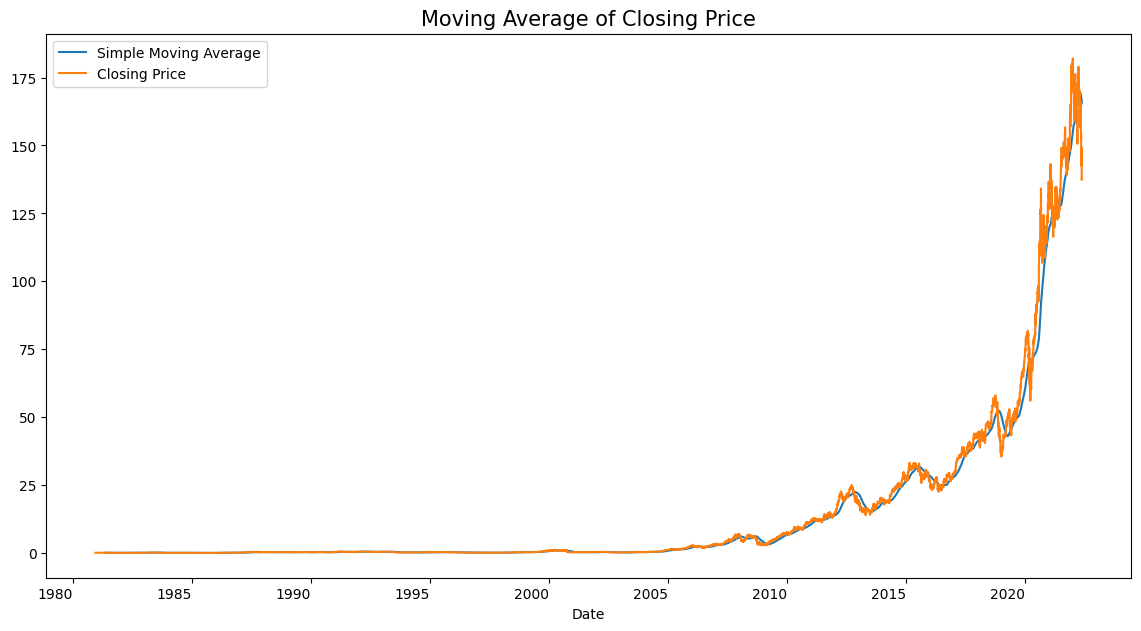

In [17]:
simple_ma = df["Close"].rolling(window=100).mean()

plt.figure(figsize=(14,8))
simple_ma.plot(label="Simple Moving Average")
df["Close"].plot(label="Closing Price")
plt.xticks(rotation=0)
plt.title("Moving Average of Closing Price", size=15)
plt.legend()
plt.show()

On average, there are 252 trading days in a year so it can be seen that there is a yearly seasonality when I pass in 252 to the parameter "period".

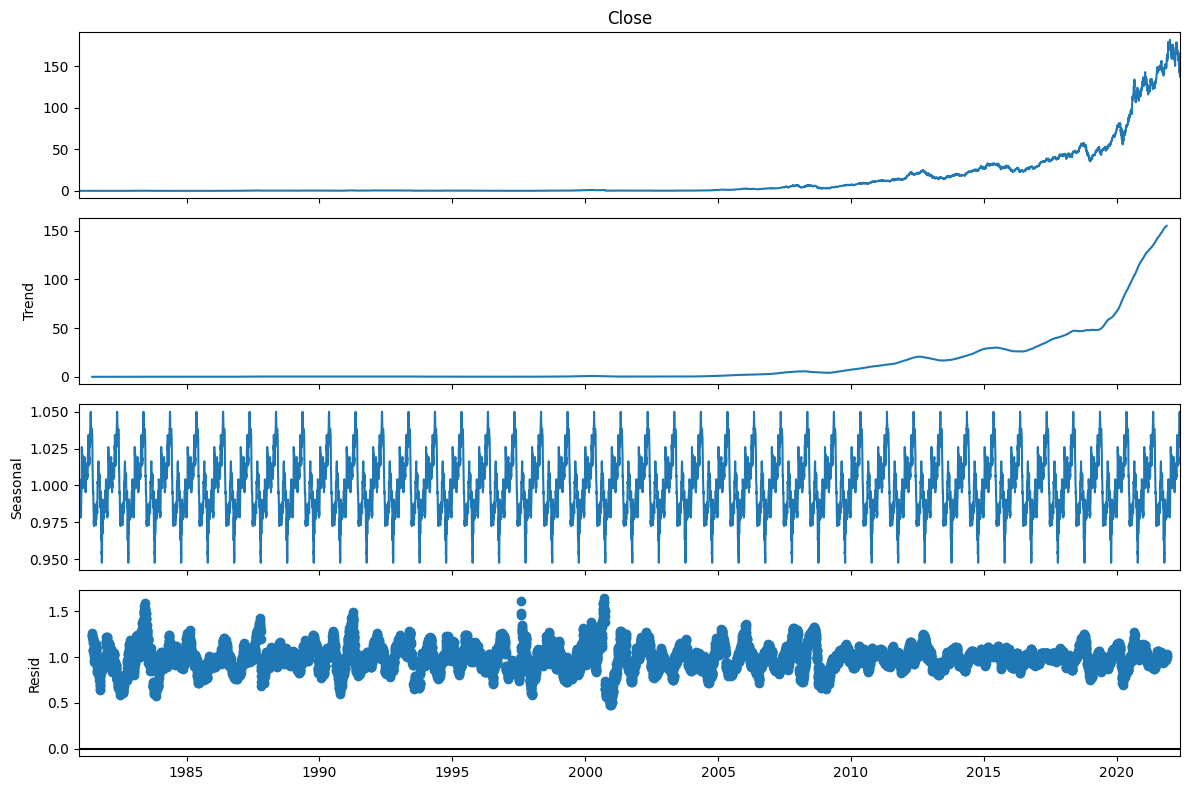

In [18]:
results = seasonal_decompose(df["Close"], model="multiplicative", period=252)
fig = results.plot()
fig.set_size_inches(12, 8)
fig.tight_layout()
plt.show()

### Data Splitting

Since the model we will be using is SARIMA, it takes a little while to train it with a seasonal length like 252. Generally, passing in 4 for quarterly data or 12 for monthly data is common. So, I sum the closing price in a month so that the data has monthly periodicity.

In [19]:
df = df.resample("MS").sum()

I preferred to take 80% of the data as train set and the rest 20% as test set.

In [20]:
df = df.reset_index()

size = int(len(df)*0.8)
train = df.loc[:size,["Date", "Close"]]
test = df.loc[size+1:, ["Date", "Close"]]

df = df.set_index("Date")
train = train.set_index("Date")
test = test.set_index("Date")

In [21]:
print("Train size:", len(train))
print("Test size:", len(test))
print("Is sum of train and test sizes equal to whole data size:", len(train)+len(test) == df["Close"].shape[0])

Train size: 399
Test size: 99
Is sum of train and test sizes equal to whole data size: True


### Checking Stationarity

I define a function for applying the Augmented Dickey-Fuller Test to the data. ADF Test tests the null hypothesis that the time series data has a unit root which means the data is non-stationary.

In [22]:
def adf_test(data):
    result = adfuller(data)
    print(f'ADF Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Number of Lags: {result[2]}')
    print(f'Number of Observations Used: {result[3]}')
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'\t{key}, {value}')

As you can see, I fail to reject H0 (null) hypothesis. Next step is to difference the data so that time series data has no unit root, hence stationary. Meaning that the data has constant mean and variance over time.

In [23]:
adf_test(train["Close"])

ADF Test Statistic: 0.5938025985647598
p-value: 0.9874618735753615
Number of Lags: 16
Number of Observations Used: 382
Critial Values:
	1%, -3.4475850438570115
	5%, -2.869135963767125
	10%, -2.5708164748773332


### Removing the Stationarity

I difference the data by one step.

In [24]:
differenced_df = train["Close"] - train["Close"].shift()

After applying the ADF test to the differenced data, I have enough evidence to reject null hypothesis as p value is way too lower than 0.05. In this place, I have seen that differencing the data by one step is enough for making the data stationary so I decide the "d" value as 1.

In [25]:
adf_test(differenced_df.dropna())

ADF Test Statistic: -4.220632233512685
p-value: 0.0006078701574850595
Number of Lags: 17
Number of Observations Used: 380
Critial Values:
	1%, -3.4476763783532585
	5%, -2.869176103659426
	10%, -2.570837873961219


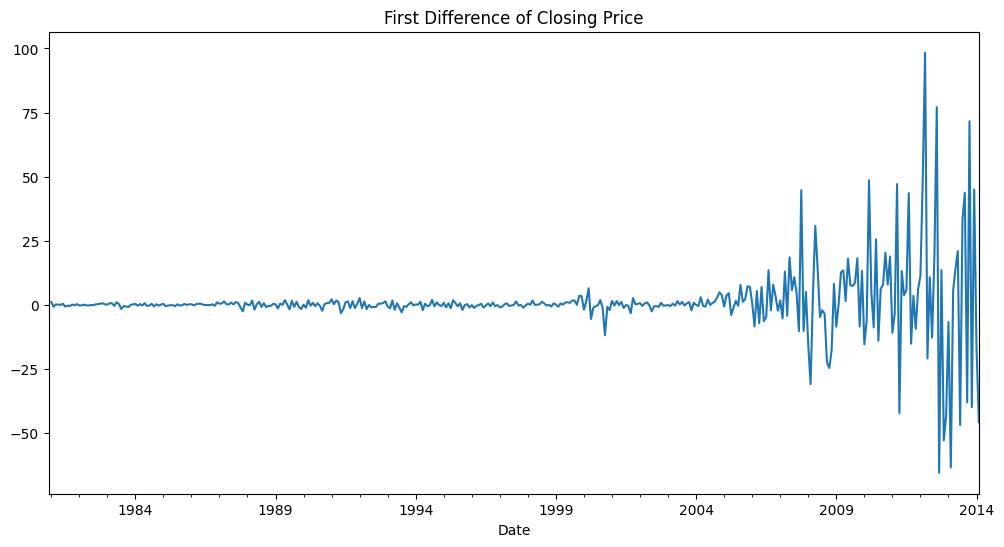

In [26]:
plt.figure(figsize=(12, 6))
differenced_df.plot()
plt.title("First Difference of Closing Price")
plt.show()

### Determining the p and q Values

SARIMA model is comprised of 4 parts; S (Seasonal), p (Autoregressive), d (Integrated) and q (Moving Average). As I already know d value and what kind of seasonality is present in the data, there are one thing left to do: determining p and q values (p for AR part and q for MA). I simply plot the Autocorrelation and Partial Autocorrelation graphs for determining q and p values respectively. Looking at the ACF and PACF plot, it can be observed that first lags of each plot are outside the blue area meaning that those values are statistically significant. So I determine the p and q values as 1.

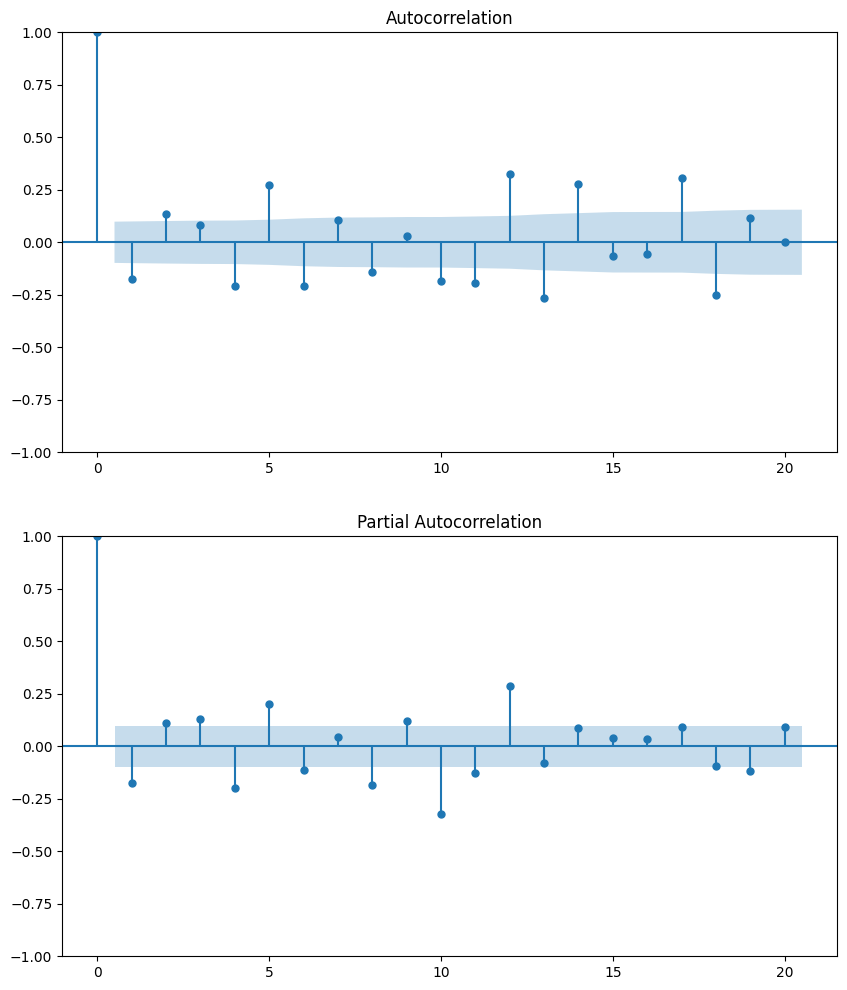

In [27]:
fig, ax = plt.subplots(2 ,1, figsize=(10, 12))
plot_acf(differenced_df.iloc[1:], lags=20, ax=ax[0])
plot_pacf(differenced_df.iloc[1:], lags=20, ax=ax[1])
plt.show()

# Model Building

Since the data contains the sum of closing prices in a month, I drop the date August 2022 because I make this project in the August 2022 and we can only calculate the sum of closing prices of this month in September 2022 (which is future).

In [30]:
if "2022-08-01" in df.index:
    df.drop("2022-08-01", axis=0, inplace=True)
df = df.reset_index(drop=True)  # Reset the index without adding the old index as a column


I decided to build a SARIMA model because of the yearly seasonality present in the data.

In [32]:
sarima = sm.tsa.statespace.SARIMAX(df.loc[:73, "Close"], order=(1,1,1), seasonal_order=(1,1,1,12))
results = sarima.fit()

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   74
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -43.542
Date:                            Thu, 22 Feb 2024   AIC                             97.083
Time:                                    04:43:20   BIC                            107.638
Sample:                                         0   HQIC                           101.220
                                             - 74                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7052      0.698      1.010      0.313      -0.663       2.074
ma.L1         -0.6323      0.764     -0.827      0.408      -2.130       0.866
ar.S.L12      -0.0017      0.274     -0.006      0.995      -0.538       0.535
ma.S.L12      -0.9908     18.141     -0.055      0.956     -36.546      34.564
sigma2         0.1726      3.091      0.056      0.955      -5.887       6.232
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.57   Prob(JB):                         0.86
Heteroskedasticity (H):               0.43   Skew:                            -0.13
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
df["forecast_train"] = results.predict(start=0, end=73)

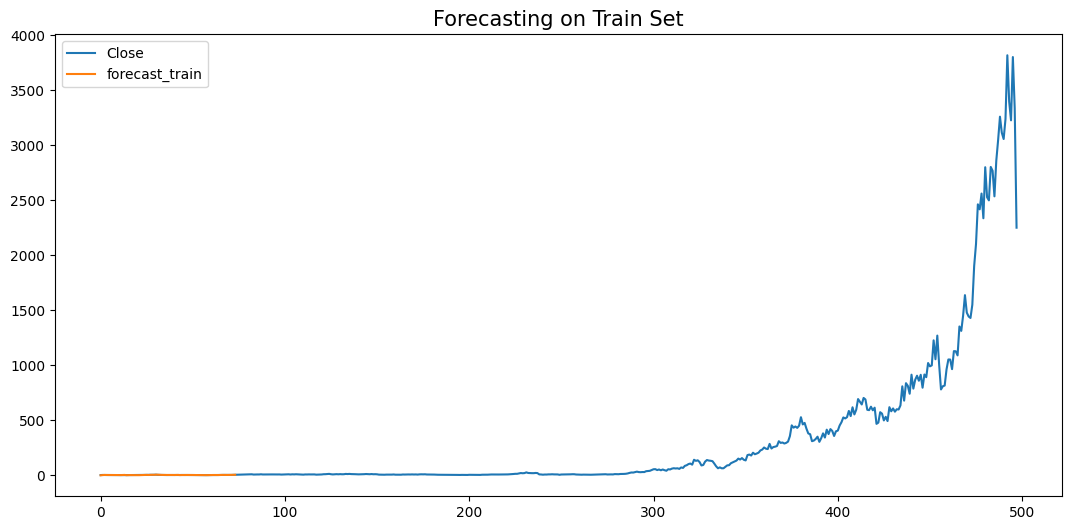

In [35]:
df[["Close", "forecast_train"]].plot(figsize=(13,6))
plt.title("Forecasting on Train Set", size=15)
plt.show()

In [36]:
df["forecast_test"] = results.forecast(17)

In [37]:
df.tail(20)

,Open,High,Low,Close,Adj Close,Volume,forecast_train,forecast_test
478,2567.269990,2602.040016,2528.049988,2561.090012,2534.057793,2894666500,NaN,NaN
479,2334.970016,2363.979973,2308.209999,2336.519987,2315.072990,2123077300,NaN,NaN
480,2797.310014,2829.380013,2766.009972,2800.390007,2775.612329,2322189600,NaN,NaN
481,2528.920014,2566.330045,2488.599991,2527.700005,2505.335183,2240262000,NaN,NaN
482,2508.429992,2528.270012,2468.659995,2499.099997,2479.889090,1833855600,NaN,NaN
483,2808.010020,2839.850006,2769.310005,2803.039986,2782.390427,2650418200,NaN,NaN
484,2765.120019,2791.139999,2739.770014,2768.070016,2747.678103,1889857500,NaN,NaN
485,2540.700013,2563.160001,2516.479988,2535.679999,2520.401651,1711934900,NaN,NaN
486,2848.770020,2874.340025,2832.749999,2859.089991,2842.848124,1606590000,NaN,NaN
487,3035.980041,3071.300034,3014.309999,3047.930007,3030.615401,1919035100,NaN,NaN


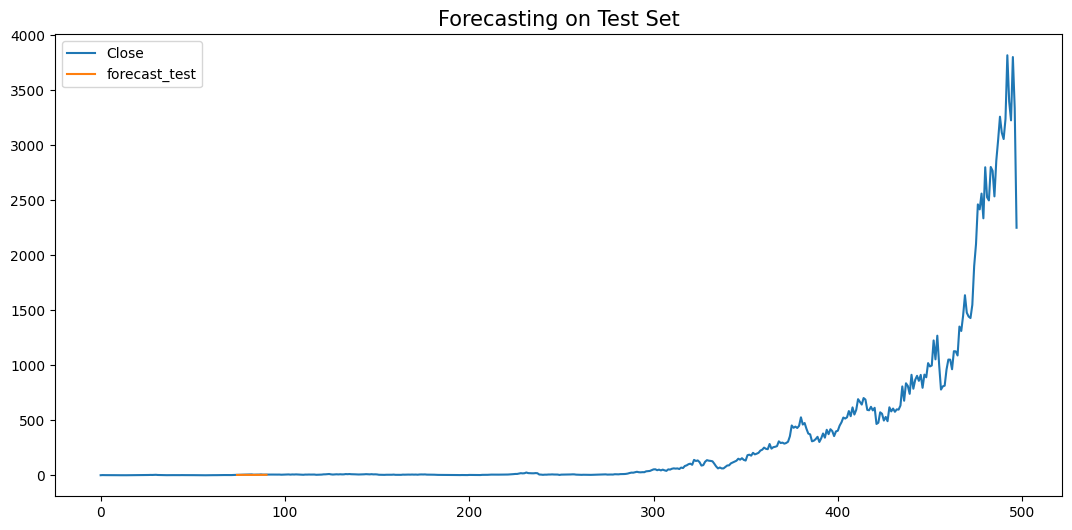

In [38]:
df[["Close", "forecast_test"]].plot(figsize=(13,6))
plt.title("Forecasting on Test Set", size=15)
plt.show()

In [39]:
print("Model Performance on Train Set")
print("-"*20)
print("Mean Absolute Error (MAE):", mean_absolute_error(df.loc[:73,"Close"], df.loc[:73,"forecast_train"]))
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(df.loc[:73,"Close"], df.loc[:73,"forecast_train"]))

Model Performance on Train Set
--------------------
Mean Absolute Error (MAE): 0.4100199887600725
Mean Absolute Percentage Error (MAPE): 0.18092041720208832


In [42]:
# Drop rows with NaN values in 'Close' or 'forecast_test' columns
df_test = df.loc[74:, ['Close', 'forecast_test']].dropna()

print("Model Performance on Test Set")
print("-" * 30)
print("Mean Absolute Error (MAE):", mean_absolute_error(df_test['Close'], df_test['forecast_test']))
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(df_test['Close'], df_test['forecast_test']))


Model Performance on Test Set
------------------------------
Mean Absolute Error (MAE): 2.9036715910719932
Mean Absolute Percentage Error (MAPE): 0.3627510878973296


# Forecasting Closing Price From August 2022 to 2023

It's time to forecast the sum of closing prices of future months from August 2022 to 2023 (excluding January 2023). I create future dates to predict the corresponding closing prices.

In [45]:
df.index = pd.to_datetime(df.index)

future_dates = [df.index[-1] + pd.DateOffset(months=x) for x in range(1, 6)]
future_df = pd.DataFrame(index=future_dates, columns=df.columns)
df_for_forecast = pd.concat([df, future_df])

df_for_forecast = df_for_forecast.reset_index()
df_for_forecast.rename(columns={"index": "Date"}, inplace=True)


In [46]:
df_for_forecast["future_forecast"] = results.predict(start=90, end=95)

In [47]:
df_for_forecast = df_for_forecast.set_index("Date")
df_for_forecast["future_forecast"].tail()

Date
1970-02-01 00:00:00.000000497   NaN
1970-03-01 00:00:00.000000497   NaN
1970-04-01 00:00:00.000000497   NaN
1970-05-01 00:00:00.000000497   NaN
1970-06-01 00:00:00.000000497   NaN
Name: future_forecast, dtype: float64

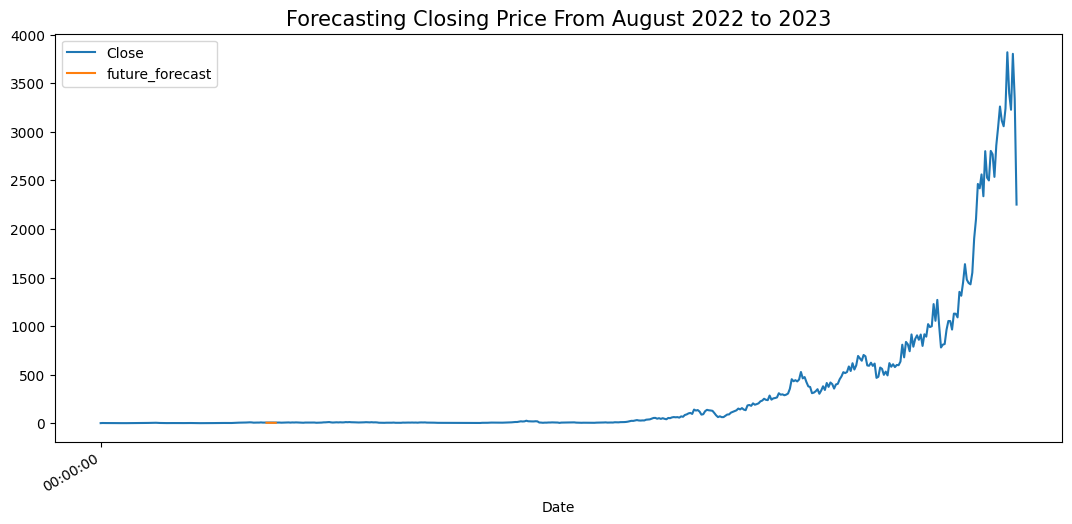

In [48]:
df_for_forecast[["Close", "future_forecast"]].plot(figsize=(13,6))
plt.title("Forecasting Closing Price From August 2022 to 2023", size=15)
plt.show()